# Virtual Environment

In [24]:
!poetry env use 3.12
!poetry env activate

Using virtualenv: C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12
"C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12\Scripts\activate.bat"


In [25]:
!poetry install
!poetry lock
#!poetry run pip freeze
    # ipykernel
    # keras
    # matplotlib
    # numpy
    # ruff
    # seaborn
    # tensorflow

Installing dependencies from lock file

No dependencies to install or update
Resolving dependencies...


# Set Seed

In [26]:
import os

In [27]:
SEED = 727

In [28]:
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setup Imports

In [29]:
import keras
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [30]:
from numpy._typing._array_like import NDArray
import os
from pathlib import Path
from PIL import Image, ImageEnhance
from typing import Any
import random
import shutil

IMAGE_SIZE: tuple[int, int] = (64, 64)
IMAGE_SUFFIXES: set[str] = {'.jpeg', '.jpg', '.png'}

# Load Datasets

In [31]:
ROOT_PATH: Path = Path.cwd().parent
TRAIN_PATH: Path = ROOT_PATH / 'data' / 'train'
TEST_PATH: Path = ROOT_PATH / 'data' / 'test'

TRAIN_CHECKPOINT_PATH: Path = Path.cwd() / 'checkpoints'

In [32]:
def load_image_from_path(image_path: Path) -> list[int]:
    image: Image.Image = Image.open(image_path).convert('RGB').resize(IMAGE_SIZE)
    image = ImageEnhance.Color(image).enhance(2.0)

    image_flat: NDArray[Any] = np.asarray(image, dtype="int64").flatten()

    ret: list[int] = [int(i) for i in image_flat]
    return ret

In [33]:
def get_dataset_classes(dataset_path: Path) -> list[str]:
    return [d.name for d in dataset_path.iterdir() if d.is_dir()]

In [34]:
def load_dataset_from_directory(dataset_path: Path) -> pd.DataFrame:
    dataset_classes: list[str] = get_dataset_classes(dataset_path)

    labels: list[str] = ['label']
    for i in range(IMAGE_SIZE[0]):
        for j in range(IMAGE_SIZE[1]):
            for k in ['r', 'g', 'b']:
                labels.append(f'pixel{i*IMAGE_SIZE[0] + j}_{k}')

    data: dict[str, list[int]] = {}
    for label in labels:
        data[label] = []
    for d_c, dataset_class in enumerate(dataset_classes):
        for image_path in (dataset_path / dataset_class).iterdir():
            if not image_path.is_file() or image_path.suffix not in IMAGE_SUFFIXES:
                continue

            row: list[int] = []
            row.append(d_c)
            row.extend(load_image_from_path(image_path))

            for i in range(len(labels)):
                data[labels[i]].append(row[i])

    ret: pd.DataFrame = pd.DataFrame(
        data=data,
        )

    return ret

In [35]:
train: pd.DataFrame = load_dataset_from_directory(TRAIN_PATH)
print(train.shape)
train.head()

(3350, 12289)


,label,pixel0_r,pixel0_g,pixel0_b,pixel1_r,pixel1_g,pixel1_b,pixel2_r,pixel2_g,pixel2_b,pixel3_r,pixel3_g,pixel3_b,pixel4_r,pixel4_g,pixel4_b,pixel5_r,pixel5_g,pixel5_b,pixel6_r,pixel6_g,pixel6_b,pixel7_r,pixel7_g,pixel7_b,pixel8_r,pixel8_g,pixel8_b,pixel9_r,pixel9_g,pixel9_b,pixel10_r,pixel10_g,pixel10_b,pixel11_r,pixel11_g,pixel11_b,pixel12_r,pixel12_g,pixel12_b,...,pixel4082_b,pixel4083_r,pixel4083_g,pixel4083_b,pixel4084_r,pixel4084_g,pixel4084_b,pixel4085_r,pixel4085_g,pixel4085_b,pixel4086_r,pixel4086_g,pixel4086_b,pixel4087_r,pixel4087_g,pixel4087_b,pixel4088_r,pixel4088_g,pixel4088_b,pixel4089_r,pixel4089_g,pixel4089_b,pixel4090_r,pixel4090_g,pixel4090_b,pixel4091_r,pixel4091_g,pixel4091_b,pixel4092_r,pixel4092_g,pixel4092_b,pixel4093_r,pixel4093_g,pixel4093_b,pixel4094_r,pixel4094_g,pixel4094_b,pixel4095_r,pixel4095_g,pixel4095_b
0,0,136,152,190,139,155,193,133,149,185,136,154,190,153,171,203,136,152,186,139,155,187,146,162,198,143,159,195,144,160,196,148,162,200,150,164,202,149,165,199,...,132,253,201,131,255,201,131,255,201,129,254,200,126,255,201,129,255,200,124,255,197,121,255,199,123,255,199,123,255,197,121,255,194,116,255,193,115,254,188,106
1,0,119,101,143,118,100,142,118,100,142,121,103,145,121,105,147,119,103,145,119,103,145,119,103,145,118,102,144,118,102,144,116,100,142,115,99,141,114,98,140,...,171,124,156,150,126,160,146,103,147,121,99,147,111,116,146,114,184,168,174,193,169,183,194,172,184,196,174,186,197,175,187,197,175,187,196,174,186,193,171,183
2,0,161,155,141,165,177,185,118,104,106,128,92,86,123,79,71,119,77,73,198,128,108,246,174,144,246,174,138,154,108,88,171,125,113,167,119,107,182,140,126,...,131,139,125,129,120,102,102,103,83,83,116,96,94,119,97,95,119,101,97,131,111,113,102,80,80,70,52,58,112,82,76,103,71,59,96,68,62,75,55,55
3,0,117,149,0,121,137,0,88,114,0,79,101,0,69,93,0,56,92,0,61,93,0,54,84,0,120,86,0,144,98,4,99,101,9,162,86,10,130,60,12,...,0,96,174,0,75,155,0,59,139,0,49,125,0,46,120,0,63,129,0,54,124,0,44,114,0,43,113,0,42,108,0,39,105,0,39,103,0,45,105,0
4,0,33,57,91,82,104,68,175,191,97,240,236,142,249,245,145,211,217,115,54,74,10,16,38,8,22,50,20,1,31,3,55,89,37,83,123,57,27,63,29,...,12,94,92,28,79,87,17,61,71,17,28,26,4,26,22,4,23,19,9,23,17,3,102,40,38,174,66,64,213,79,63,246,100,60,255,112,58,255,121,57


In [36]:
'''
test: pd.DataFrame = load_dataset_from_directory(TEST_PATH)
print(test.shape)
#test.head()
'''

'\ntest: pd.DataFrame = load_dataset_from_directory(TEST_PATH)\nprint(test.shape)\n#test.head()\n'

# Reset Seed

- if only tweaking model parameters (after already running the entire notebook once), then just **Execute Cell and Below** from here (no need to reload entire dataset)

In [37]:
def set_seeds(seed: int) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [38]:
set_seeds(SEED)

# Data Preprocessing

## Create DataFrames

In [39]:
Y_train: pd.Series = train['label']
X_train: pd.DataFrame = train.drop(
    labels = ['label'],
    axis = 1
    ) 
Y_train.value_counts()

label
1    1045
3     929
0     917
2     459
Name: count, dtype: int64

## Normalization, Reshape and Label Encoding 

In [40]:
NUM_CLASSES: int = len(get_dataset_classes(TRAIN_PATH))
NUM_CLASSES

4

In [41]:
# normalize train data
X_train /= 255.0
X_train *= X_train
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 12288)


In [42]:
'''
test /= 255.0
print("test shape: ", test.shape)
'''

'\ntest /= 255.0\nprint("test shape: ", test.shape)\n'

In [43]:
# reshape, supports shape inference using `-1` as dimension
X_train: pd.DataFrame = X_train.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 64, 64, 3)


In [44]:
'''
test = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print("test shape: ", test.shape)
'''

'\ntest = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)\nprint("test shape: ", test.shape)\n'

In [45]:
# Label Encoding 
from keras.utils import to_categorical # convert to one-hot-encoding

Y_train: NDArray[np.float64] = to_categorical(Y_train, num_classes=NUM_CLASSES)

## Train Test Split

In [46]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2

In [47]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=TEST_SIZE, random_state=SEED)
print("x_train shape", X_train.shape)
print("x_test shape", X_val.shape)
print("y_train shape", Y_train.shape)
print("y_test shape", Y_val.shape)

x_train shape (2680, 64, 64, 3)
x_test shape (670, 64, 64, 3)
y_train shape (2680, 4)
y_test shape (670, 4)


# CNN

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [19]:
# optimizer, loss, etrics
OPTIMIZER = Adam(
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999
    )
LOSS: str = 'categorical_crossentropy'
METRICS: list[str] = ['accuracy', 'f1_score', 'precision', 'recall']

# epochs, batch size
EPOCHS = 120
BATCH_SIZE = 32

In [48]:
# CNN model layers
model = Sequential()

#
model.add(Conv2D(
    filters = 8,
    kernel_size = (5,5),
    padding = 'Same', 
    activation ='relu',
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    ))
model.add(MaxPool2D(
    pool_size = (3,3)
    ))
model.add(Dropout(0.25))

#
model.add(Conv2D(
    filters = 16,
    kernel_size = (3,3),
    padding = 'Same', 
    activation ='relu'))
model.add(MaxPool2D(
    pool_size = (3,3),
    strides = (2,2)
    ))
model.add(Dropout(0.4))

# fully connected
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [49]:
# compile the model
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
    )

In [50]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # dimemsion reduction
        rotation_range = 90,  # randomly rotate images in the range 90 degrees
        zoom_range = 0.2, # Randomly zoom image 20%
        width_shift_range = 0.1,  # randomly shift images horizontally 10%
        height_shift_range = 0.1,  # randomly shift images vertically 10%
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True)  # randomly flip images

datagen.fit(
    X_train,
    seed=SEED
    )

In [51]:
# if checkpoint folder exists, then delete all existing checkpoints
if TRAIN_CHECKPOINT_PATH.exists():
    for checkpoint_path in TRAIN_CHECKPOINT_PATH.iterdir():
        if checkpoint_path.is_file():
            checkpoint_path.unlink()

# add a ModelCheckpoint to save new best models
model_checkpoint = ModelCheckpoint(
    filepath = TRAIN_CHECKPOINT_PATH / 'checkpoint_{epoch:03d}-{val_loss:.4f}.keras', 
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    save_freq = 'epoch'
    )

In [34]:
# fit the model
history = model.fit(
    datagen.flow(
        X_train, Y_train,
        batch_size = BATCH_SIZE
    ),
    epochs = EPOCHS,
    validation_data = (X_val, Y_val),
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
    callbacks = [model_checkpoint],
    )

Epoch 1/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4888 - f1_score: 0.4229 - loss: 1.1369 - precision: 0.6762 - recall: 0.2221 - val_accuracy: 0.7537 - val_f1_score: 0.6228 - val_loss: 0.6214 - val_precision: 0.7993 - val_recall: 0.6896
Epoch 2/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - f1_score: 0.6115 - loss: 0.5099 - precision: 0.8571 - recall: 0.7500 - val_accuracy: 0.7522 - val_f1_score: 0.6086 - val_loss: 0.6125 - val_precision: 0.8094 - val_recall: 0.6970
Epoch 3/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7667 - f1_score: 0.6769 - loss: 0.5921 - precision: 0.8035 - recall: 0.7118 - val_accuracy: 0.7970 - val_f1_score: 0.7143 - val_loss: 0.5256 - val_precision: 0.8586 - val_recall: 0.7343
Epoch 4/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - f1_score: 0.6559 - loss: 0.3996 - precision: 0.8710 - recall: 0.8438 - val_accuracy: 0.7836 - val_f1_score: 0.6691 - val_loss: 0.5321 - val_precision: 0.8562 - val_recall: 0

# Evaluation Metrics

## History Curves

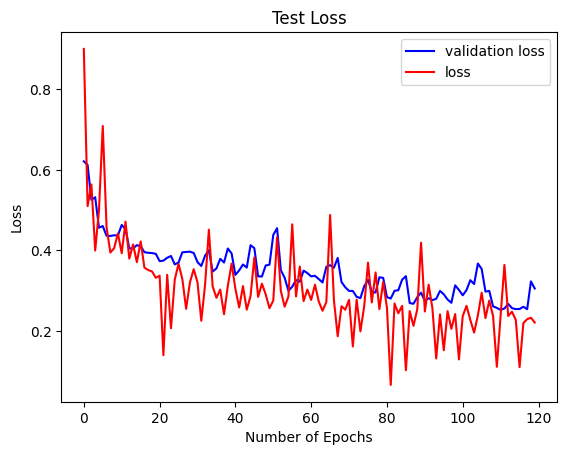

In [35]:
# Plot the loss curves for training and validation 
plt.plot(
    history.history['val_loss'],
    color='b',
    label="validation loss"
    )
plt.plot(
    history.history['loss'],
    color='r',
    label="loss"
    )

# set plot title and axis labels
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

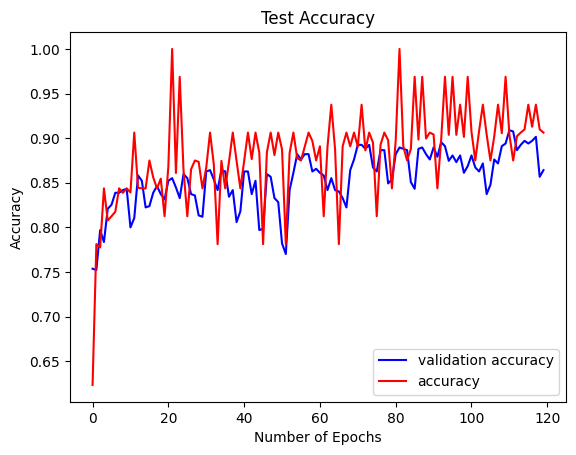

In [36]:
# Plot the accuracy curves for training and validation
if 'accuracy' in METRICS:
    plt.plot(
        history.history['val_accuracy'],
        color='b',
        label="validation accuracy"
        )
    plt.plot(
        history.history['accuracy'],
        color='r',
        label="accuracy"
        )

    # set plot title and axis labels
    plt.title("Test Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # show plot
    plt.show()

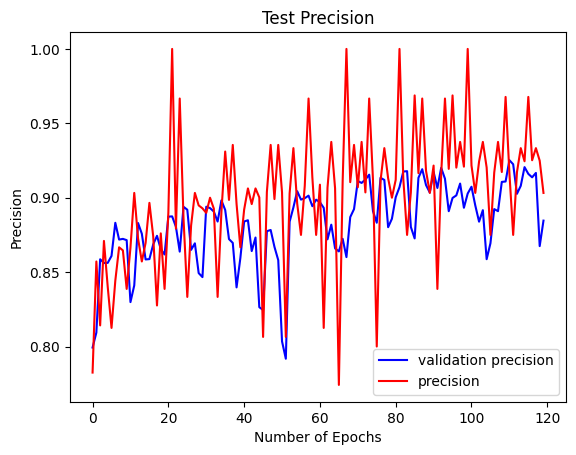

In [37]:
# Plot the precision curves for training and validation 
if 'precision' in METRICS:
    plt.plot(
        history.history['val_precision'],
        color='b',
        label="validation precision"
        )
    plt.plot(
        history.history['precision'],
        color='r',
        label="precision"
        )

    # set plot title and axis labels
    plt.title("Test Precision")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Precision")
    plt.legend()

    # show plot
    plt.show()

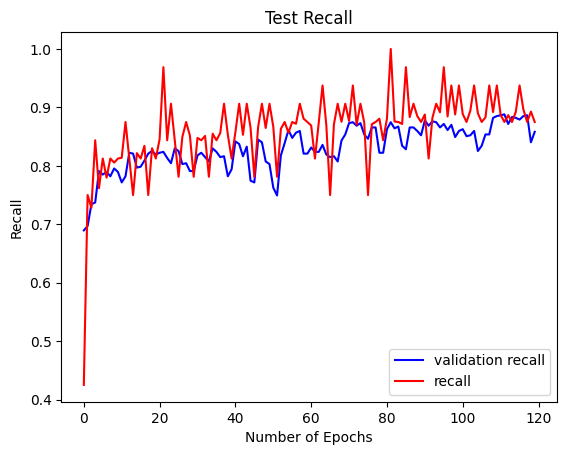

In [38]:
# Plot the recall curves for training and validation
if 'recall' in METRICS:
    plt.plot(
        history.history['val_recall'],
        color='b',
        label="validation recall"
        )
    plt.plot(
        history.history['recall'],
        color='r',
        label="recall"
        )

    # set plot title and axis labels
    plt.title("Test Recall")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Recall")
    plt.legend()

    # show plot
    plt.show()

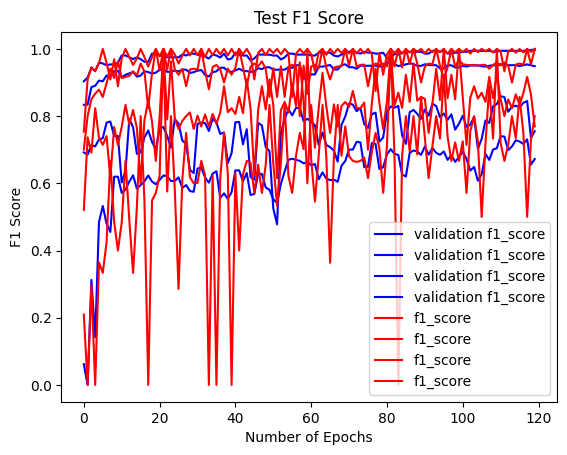

In [39]:
# Plot the F1 score curves for training and validation
if 'f1_score' in METRICS:
    plt.plot(
        history.history['val_f1_score'],
        color='b',
        label="validation f1_score"
        )
    plt.plot(
        history.history['f1_score'],
        color='r',
        label="f1_score"
        )

    # set plot title and axis labels
    plt.title("Test F1 Score")
    plt.xlabel("Number of Epochs")
    plt.ylabel("F1 Score")
    plt.legend()

    # show plot
    plt.show()

## Confusion Matrix

In [56]:
# load best saved weights into model
for checkpoint_path in TRAIN_CHECKPOINT_PATH.iterdir():
    model = keras.saving.load_model(checkpoint_path)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


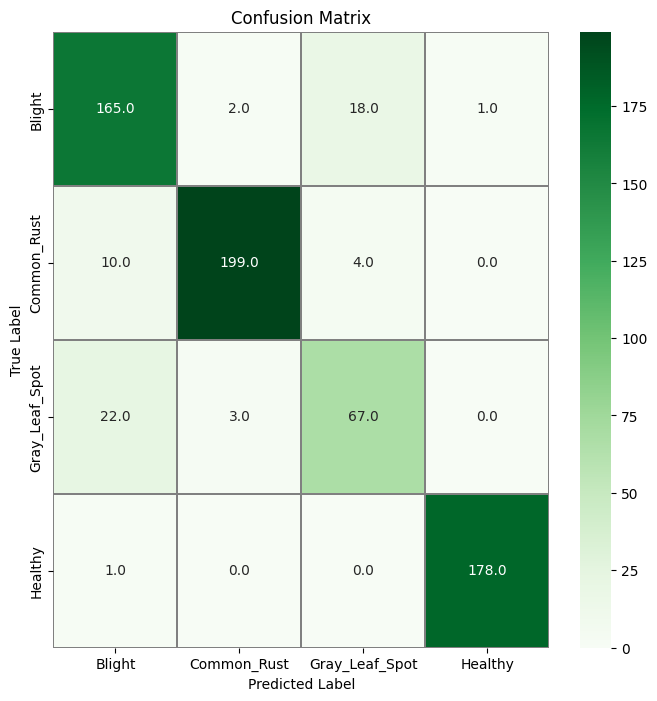

In [57]:
# confusion matrix

# Predict the values from the validation dataset
from numpy import ndarray

Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx: ndarray[Any, Any] = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f: matplotlib.figure.Figure; ax: plt.Axes
f, ax = plt.subplots(figsize=(8, 8))

# generate confusion matrix as heatmap
sns.heatmap(
    confusion_mtx,
    annot=True,
    linewidths=0.01,
    cmap="Greens",
    linecolor="gray",
    fmt='.1f',
    ax=ax,
    xticklabels=get_dataset_classes(TRAIN_PATH),
    yticklabels=get_dataset_classes(TRAIN_PATH),
    )

# set title and axis labels of confusion matrix
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# show confusion matrix
plt.show()

In [58]:
confusion_mtx

array([[165,   2,  18,   1],
       [ 10, 199,   4,   0],
       [ 22,   3,  67,   0],
       [  1,   0,   0, 178]])

## Classification Report

In [62]:
print(classification_report(Y_true, Y_pred_classes, target_names=get_dataset_classes(TRAIN_PATH)))

                precision    recall  f1-score   support

        Blight       0.83      0.89      0.86       186
   Common_Rust       0.98      0.93      0.95       213
Gray_Leaf_Spot       0.75      0.73      0.74        92
       Healthy       0.99      0.99      0.99       179

      accuracy                           0.91       670
     macro avg       0.89      0.89      0.89       670
  weighted avg       0.91      0.91      0.91       670



# Export Results

## Save Best Model

In [ ]:
BEST_MODEL_FILENAME: str = 'model.keras'

In [ ]:
BEST_MODEL_PATH: Path = Path.cwd() / 'final' / BEST_MODEL_FILENAME

keras.saving.save_model(model, BEST_MODEL_PATH)

## Save CSV

In [ ]:
CSV_FILENAME = 'predictions.csv'

In [ ]:
def predict_images(image_directory: Path) -> list[tuple[str, str]]:
    image_paths: list[Path] = [image_path for image_path in image_directory.iterdir() if image_path.is_file() and image_path.suffix in IMAGE_SUFFIXES]
    images: list[Image.Image] = [Image.open(image_path).convert('RGB').resize((IMAGE_SIZE[0], IMAGE_SIZE[1])) for image_path in image_paths]
    image_arrays = np.array([
        np.array(image).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 3) for image in images
        ])

    pred = model.predict(image_arrays)
    pred_classes = np.argmax(pred, axis=1)
    predictions = [get_dataset_classes(TRAIN_PATH)[i] for i in pred_classes]

    zipped_predictions: list[tuple[Path, str]] = [(image_path, str(prediction)) for image_path, prediction in zip(image_paths, predictions)]
    zipped_predictions.sort(key=lambda l : int(l[0].stem))
    
    return [(p[0].name, p[1]) for p in zipped_predictions]

In [ ]:
CSV_PATH: Path = Path.cwd() / 'final' / CSV_FILENAME

with open(CSV_PATH, 'w') as csv_file:
    csv_file.write('\n'.join(map(','.join, predict_images(TEST_PATH))))

predict_images(TEST_PATH)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[('0.jpeg', 'Healthy'),
 ('1.jpeg', 'Healthy'),
 ('2.jpeg', 'Healthy'),
 ('3.jpeg', 'Healthy'),
 ('4.jpeg', 'Healthy'),
 ('5.jpeg', 'Healthy'),
 ('6.jpeg', 'Healthy'),
 ('7.jpeg', 'Healthy'),
 ('8.jpeg', 'Healthy'),
 ('9.jpeg', 'Healthy'),
 ('10.jpeg', 'Healthy'),
 ('11.jpeg', 'Healthy'),
 ('12.jpeg', 'Healthy'),
 ('13.jpeg', 'Healthy'),
 ('14.jpeg', 'Healthy'),
 ('15.jpeg', 'Healthy'),
 ('16.jpeg', 'Healthy'),
 ('17.jpeg', 'Healthy'),
 ('18.jpeg', 'Healthy'),
 ('19.jpeg', 'Healthy'),
 ('20.jpeg', 'Healthy'),
 ('21.jpeg', 'Healthy'),
 ('22.jpeg', 'Healthy'),
 ('23.jpeg', 'Healthy'),
 ('24.jpeg', 'Healthy'),
 ('25.jpeg', 'Healthy'),
 ('26.jpeg', 'Healthy'),
 ('27.jpeg', 'Healthy'),
 ('28.jpeg', 'Healthy'),
 ('29.jpeg', 'Healthy'),
 ('30.jpeg', 'Healthy'),
 ('31.jpeg', 'Healthy'),
 ('32.jpeg', 'Healthy'),
 ('33.jpeg', 'Healthy'),
 ('34.jpeg', 'Healthy'),
 ('35.jpeg', 'Healthy'),
 ('36.jpeg', 'Healthy'),
 ('37.jpeg', 'Healthy'),
 ('38.jpeg', 'Healthy'),
 ('39.jpeg', 'Healthy'),
 ('40.jpeg